In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.26, Omega_b = 0.04, h = 0.7, sigma8 = 0.8, n_s = 0.96, matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:965: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (8.333333333333334e-12)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:967: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (600000000.0)
  warnings.warn(f"Increase integral upper limit, r_max_int ({self.r_max_int}) < maximum radius ({np.max(r)})", UserWarning)


Text(0.5, 0, 'R [Mpc]')

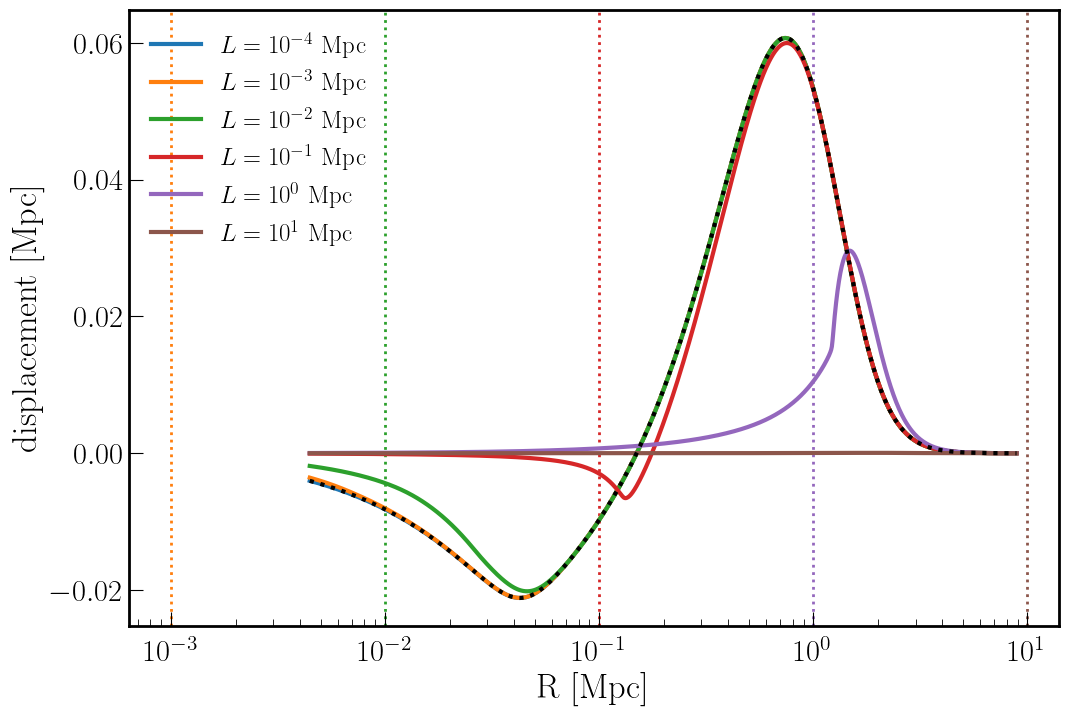

In [4]:
plt.figure(figsize = (12,8))
plt.xscale('log')

M = 1e13
a = 1
R200c = ccl.halos.massdef.MassDef200c.get_radius(cosmo, M, a)
R = np.geomspace(0.01 * R200c, 20 * R200c, 1000)
x = R/R200c

DMO = bfg.Profiles.DarkMatterOnly(**bpar)
DMB = bfg.Profiles.DarkMatterBaryon(**bpar)

#Setting CCL fft params to higher precision
for p in [DMO, DMB]:
    p.update_precision_fftlog(padding_lo_fftlog = 1e-5, padding_hi_fftlog = 1e5, n_per_decade = 1000)

Baryons = bfg.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo)
Baryons.setup_interpolator(z_min = 0, z_max = 1, N_samples_z = 2, R_min = 1e-5, R_max = 5e3,
                           z_linear_sampling = True, verbose = False, N_samples_R = 10_000);
plt.plot(R, Baryons.displacement(R * a, M, a), color = 'k', lw = 3, zorder = 100, ls = ':')

pixels = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
for i in range(len(pixels)):
    
    Pix = bfg.utils.GridPixelApprox(pixels[i])
    DMO_pixel = bfg.utils.ConvolvedProfile(DMO, Pix)
    DMB_pixel = bfg.utils.ConvolvedProfile(DMB, Pix)

    #We will get warnings from this step, because the FFTlog tries to compute the profile
    #in some really extreme parts of param space. This is fine!
    Baryons = bfg.Profiles.Baryonification3D(DMO_pixel, DMB_pixel, cosmo = cosmo)
    Baryons.setup_interpolator(z_min = 0, z_max = 1, N_samples_z = 2, R_min = 1e-5, R_max = 5e3,
                               z_linear_sampling = True, verbose = False, N_samples_R = 10_000);

    text = r'$L = 10^{%d}$ Mpc' % int(np.log10(pixels[i]))
    c = plt.plot(R, Baryons.displacement(R * a, M, a), lw = 3, label = text)
    
    if pixels[i] > R[0] * 0.1: #Don't show vertical line for reaaaally small pixels
        plt.axvline(pixels[i], color = c[0].get_color(), ls = ':', lw = 2, zorder = -100)
    
plt.tick_params(axis = 'x', pad = 10)
plt.legend(fontsize = 18, loc = 'upper left')

plt.ylabel('displacement [Mpc]', size = 25)
plt.xlabel(r'R [Mpc]', size = 25)